In [74]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path, size=12)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('final_merged_df_correction.csv')
df = df.drop(columns=['시점'])
df.head(), df.shape, df['지역별'].unique(), df['지역별'].unique().shape


(  지역별  아파트매매가격지수    인구밀도  사교육참여율   고용률  여성초혼연령  인터넷이용률  합계출산율   근로시간
 0  강원       82.1    90.2    61.6  51.7   29.62    74.1  1.311  173.1
 1  경기       89.6  1227.9    71.7  60.8   30.04    86.3  1.272  175.2
 2  경남      105.3   316.4    65.7  58.3   29.76    86.4  1.437  172.2
 3  경북      109.4   140.8    64.2  59.2   29.55    86.6  1.464  170.6
 4  광주       87.7  2998.5    66.0  57.6   30.09    90.2  1.207  171.5,
 (1728, 9),
 array(['강원', '경기', '경남', '경북', '광주', '대구', '대전', '부산', '서울', '울산', '인천',
        '전남', '전북', '제주', '충남', '충북'], dtype=object),
 (16,))

In [75]:
# 결측치
df_copy = df.dropna()
df_copy.isnull().sum()

지역별          0
아파트매매가격지수    0
인구밀도         0
사교육참여율       0
고용률          0
여성초혼연령       0
인터넷이용률       0
합계출산율        0
근로시간         0
dtype: int64

In [76]:
# object → int
from sklearn.preprocessing import LabelEncoder

le_disaster = LabelEncoder()
df_copy.loc[:, '지역별'] = le_disaster.fit_transform(df_copy['지역별'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   지역별        1728 non-null   object 
 1   아파트매매가격지수  1728 non-null   float64
 2   인구밀도       1728 non-null   float64
 3   사교육참여율     1728 non-null   float64
 4   고용률        1728 non-null   float64
 5   여성초혼연령     1728 non-null   float64
 6   인터넷이용률     1728 non-null   float64
 7   합계출산율      1728 non-null   float64
 8   근로시간       1728 non-null   float64
dtypes: float64(8), object(1)
memory usage: 121.6+ KB


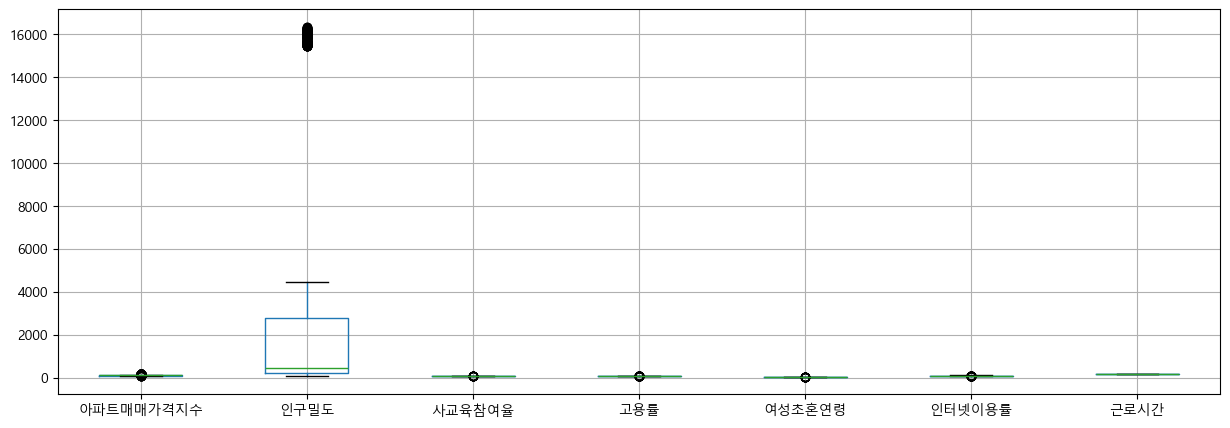

In [77]:
# 이상치 확인
import matplotlib.pyplot as plt

df_copy.drop('합계출산율', axis=1).boxplot(figsize=(15,5))
plt.show()

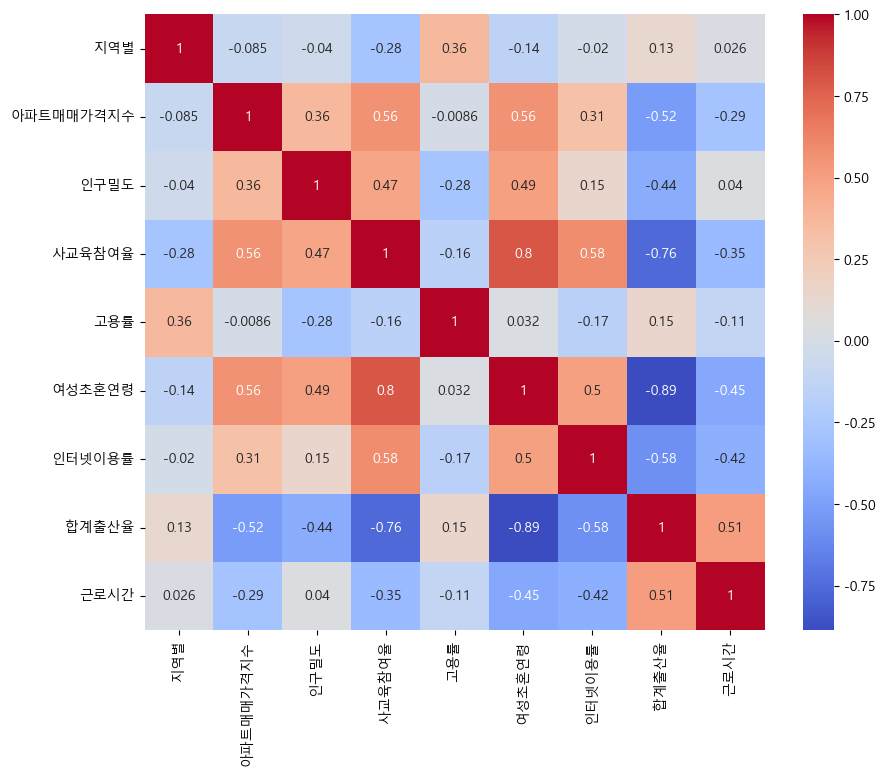

In [78]:
# 상관관계
import seaborn as sns

corr_mat = df_copy.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr_mat, annot = True, cmap = 'coolwarm')
plt.show()

In [79]:
# 왜도 확인
# df_copy.skew()

import numpy as np
df_copy.loc[:, '인구밀도'] = np.log1p(df_copy['인구밀도'])
df_copy.skew()

지역별               0.0
아파트매매가격지수    1.880663
인구밀도         0.319378
사교육참여율       0.114087
고용률          0.587394
여성초혼연령       0.331966
인터넷이용률      -1.012095
합계출산율        0.347638
근로시간        -0.210719
dtype: object

In [80]:
# 데이터 분리
from sklearn.model_selection import train_test_split

X = df_copy.drop(columns=['합계출산율'])
y = df_copy['합계출산율']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index: 0, Column Name: 지역별
Index: 1, Column Name: 아파트매매가격지수
Index: 2, Column Name: 인구밀도
Index: 3, Column Name: 사교육참여율
Index: 4, Column Name: 고용률
Index: 5, Column Name: 여성초혼연령
Index: 6, Column Name: 인터넷이용률
Index: 7, Column Name: 근로시간


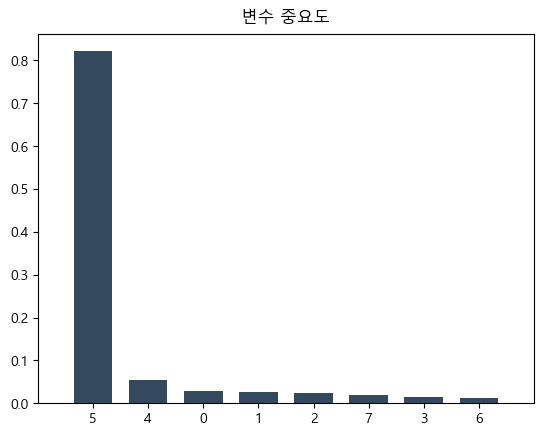

In [81]:
# 변수 중요도 확인
from sklearn.ensemble import RandomForestRegressor

for index, column in enumerate(X.columns):
    print(f'Index: {index}, Column Name: {column}')

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('변수 중요도', pad=8)

bar_width = 0.7
plt.bar(range(X.shape[1]), importances[indices], width=bar_width, color=(52/255, 73/255, 94/255, 1.0), align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [82]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
# 모델 훈련
# # DecisionTreeRegressor = 훈련:100%, 테스트:99%, mse:0.0002, r2:99%
# from sklearn.tree import DecisionTreeRegressor
# model = DecisionTreeRegressor()

# RandomForestRegressor = 훈련:99%, 테스트:99%, mse:0.0002, r2:99%
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=150)

# # GradientBoostingRegressor = 훈련:98%, 테스트:98%, mse:0.0007, r2:98%
# from sklearn.ensemble import GradientBoostingRegressor
# model = GradientBoostingRegressor()

# # # SVR = 훈련:93%, 테스트:92%, mse:0.003, r2:92%
# from sklearn.svm import SVR
# model = SVR(kernel='rbf', C=100, epsilon=0.1)

# # KNeighborsRegressor = 훈련:99%, 테스트:99%, mse:0002, r2:99%
# from sklearn.neighbors import KNeighborsRegressor
# model = KNeighborsRegressor(n_neighbors=3)

model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)

In [84]:
# 훈련 정확도
train_acc = model.score(X_train_scaled, y_train)
train_acc

0.9992404581480063

In [85]:
# 테스트 정확도
test_acc = model.score(X_test_scaled, y_test)
test_acc

0.9959299903369184

In [86]:
# MSE
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, pred)
mse

0.0001943427004495823

In [87]:
# r2_score
from sklearn.metrics import r2_score

r2 = r2_score(y_test, pred)
r2

0.9959299903369184

In [88]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train, y_train, n_repeats=20, random_state=42)
importance = result.importances_mean


c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py

Index: 0, Column Name: 지역별
Index: 1, Column Name: 아파트매매가격지수
Index: 2, Column Name: 인구밀도
Index: 3, Column Name: 사교육참여율
Index: 4, Column Name: 고용률
Index: 5, Column Name: 여성초혼연령
Index: 6, Column Name: 인터넷이용률
Index: 7, Column Name: 근로시간


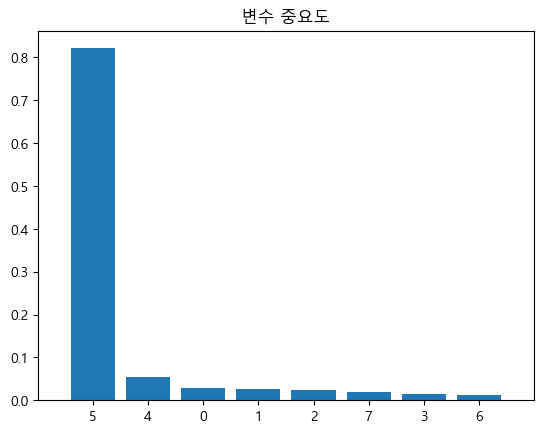

In [93]:

# 변수 중요도 확인
from sklearn.ensemble import RandomForestRegressor

for index, column in enumerate(X.columns):
    print(f'Index: {index}, Column Name: {column}')

# 랜덤 포레스트 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('변수 중요도')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [100]:
sample_data = [[11, 88.3, 4.989752 , 55.0 , 63.9, 29.41, 78.8, 170.4]]
scaled_sample_data = scaler.transform(sample_data)
model.predict(scaled_sample_data)

c:\Users\user\anaconda3\envs\myConda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1.50648667])

In [91]:
X_train

,지역별,아파트매매가격지수,인구밀도,사교육참여율,고용률,여성초혼연령,인터넷이용률,근로시간
107,11,88.3,4.989752,55.0,63.9,29.41,78.8,170.4
901,5,104.7,7.913887,66.7,58.3,30.66,96.9,156.5
1709,13,112.9,5.905362,86.3,70.8,31.68,84.3,148.0
706,2,91.2,5.764250,71.6,62.4,30.40,89.2,168.0
678,6,99.7,7.933187,74.2,58.8,30.37,94.4,166.4
...,...,...,...,...,...,...,...,...
1130,10,110.2,7.927757,74.2,61.8,30.93,93.7,167.5
1294,14,111.3,5.584999,69.0,65.2,30.47,92.0,160.6
860,12,92.5,5.414766,63.0,60.4,30.42,86.2,163.0
1459,3,105.6,4.945919,73.9,64.0,30.97,94.6,154.6


In [92]:
y_train

107     1.507
901     0.849
1709    0.750
706     1.071
678     0.918
        ...  
1130    0.787
1294    0.927
860     0.945
1459    0.889
1126    0.809
Name: 합계출산율, Length: 1382, dtype: float64